## Feeling Your Images: Visual Emotion Recognition based on Image Attributes. 
### Matias Freitas Guimaraes - matias.freitas.guimaraes@gmail.com

### Objective:
Our primary goal is to move beyond conventional approaches that predominantly focus on facial features. 
Instead, we aim to develop a robust system that comprehensively understands the visual context of an entire image, offering a nuanced interpretation of the scene.

### Background:
Computer vision, a subfield of artificial intelligence, has witnessed remarkable progress in recent years. 
However, existing models often fall short when it comes to understanding the broader context of visual information. 
Our project addresses this limitation by leveraging the capabilities of Transformer classifiers.

### Transformer Classifiers:
The Transformer architecture, originally proposed for natural language processing, has demonstrated unparalleled success in capturing long-range dependencies.
 We apply this architecture to the domain of computer vision, employing self-attention mechanisms to enable our model to consider global relationships within an image.

### Key Features:

    1. Holistic Image Understanding: Our model surpasses traditional facial-centric approaches, considering the entire image for a more comprehensive analysis.

    2. Adaptability: The Transformer's self-attention mechanism allows our model to adapt dynamically to different visual contexts, enhancing its versatility across various scenes.

    3. Robustness: By considering the entire image, our model proves to be more resilient to occlusions, variations in lighting, and other challenges that may confound traditional classifiers.

### Methodology:

    0. Dataset and Pretrained model: We used as based  EmoSet (https://vcc.tech/EmoSet) with images labeled for feelings (based on Plutchik’s Wheel of Emotions) to fine tunning the pretrained model made by Google (https://huggingface.co/google/vit-base-patch16-224) as base of our project.
    
    1. Data Processing: We carefully process the dataset to fits on model requirements, based on the research. 
    
    2. Train and hyper parameter tunning: We train our model. We choose the hyper parameters based on Population-based Training algorithm (ray tune python library). 
    
    3. Evalutation: It's evaluate the final results using reserved part of the dataset. The two used metrics are a confusion matrix and accuracy. 
    
    4. The visual final product: A movie with captions for the predict labels.

Below, Diagram of Plutchik’s Wheel of Emotions, the theory behind of the dataset labels.

![Plutchik’s Wheel of Emotions](./WheelOfEmotions.png)

Plutchik's Wheel of Emotions is a psychological model that represents various human emotions and their relationships. Developed by Robert Plutchik, a psychologist, the wheel organizes emotions into primary, secondary, and tertiary categories based on their intensity and combinations. The wheel consists of eight primary emotions, and each primary emotion has an opposite.

Here's a breakdown of the primary emotions in Plutchik's Wheel:

    Joy - Opposite: Sadness
    Trust - Opposite: Disgust
    Fear - Opposite: Anger
    Surprise - Opposite: Anticipation
    Sadness - Opposite: Joy
    Disgust - Opposite: Trust
    Anger - Opposite: Fear
    Anticipation - Opposite: Surprise

The wheel also includes the concept of blends, where adjacent emotions can combine to form secondary emotions. For example, combining joy and trust results in love, while combining fear and surprise leads to awe.

The model is useful for understanding the complexity of human emotions and how they relate to one another. Plutchik's Wheel of Emotions can be applied in various fields, including psychology, design, and human-computer interaction, to better grasp the emotional aspects of human experiences.


The dataset labels to our training with the respective percentage for each class.

![Dataset Labels](./labels.png)

Because of the low variance of percentage between classes and the high number of samples, we decide to don't resample to uniformize the number os labels. That, together with the final results showing is harder to classify the overrepresented classes (normally, what happens is on the other way), leads us to decide to stay with all samples.

### 0. Important variables

Path to EmoSet

In [1]:
emoset_path = "EmoSet/"

Model

In [2]:
checkpoint = "google/vit-base-patch16-224-in21k"

Output folder for middle step and final models

In [3]:
middle_step = "output/"
final_step = middle_step + "GoogleViTFinalWithAddtionalData/"

Create a color for each labeled feeling.
The RGB colors are going to be used mixed to create filter for each frame of the final movie result. 

In [4]:
colors_feelings = { 'anger': [255, 0, 0], 'fear': [255, 150, 0],
                   'disgust': [255, 0, 200], "sadness": [150, 0, 255],
                  'awe': [0, 0, 255], "amusement": [255, 255, 0],
                  'excitement' :  [0, 255, 255], 'contentment' : [0, 255, 0]}

In [5]:
movie_path = 'SpiritedAway.mp4'
movie_name = 'SpiritedAway'

### 1. Processing dataset

Load and visualize label data
Put image from site here

In [6]:
import json

label = json.load(open(emoset_path + "info" + ".json", "r"))

label

{'label2idx': {'amusement': 0,
  'awe': 1,
  'contentment': 2,
  'excitement': 3,
  'anger': 4,
  'disgust': 5,
  'fear': 6,
  'sadness': 7},
 'idx2label': {'0': 'amusement',
  '1': 'awe',
  '2': 'contentment',
  '3': 'excitement',
  '4': 'anger',
  '5': 'disgust',
  '6': 'fear',
  '7': 'sadness'}}

Create json file for dataset framework based on the original json file from the EmoSet repository

In [7]:
files = ["train", "val"]
for filename in files:
    file = open(emoset_path + filename + ".json", "r")
    train = [{"label": label['label2idx'][feeling], "image": emoset_path + image, "annotation" : annotation}
             for (feeling, image, annotation) in json.load(file)]

    file = open(emoset_path + filename + "_formated.json", "w")
    file.write(json.dumps(train, ensure_ascii=False))

Load dataset

In [8]:
from datasets import load_dataset, Dataset
from datasets import Image as ImageDS

data_files = {"train": "train_formated.json", "test": "test_formated.json",
              "val": "val_formated.json"}

dataset = load_dataset(emoset_path, data_files=data_files)

dataset["train"][0]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

{'image': 'EmoSet/image/amusement/amusement_08258.jpg',
 'annotation': 'annotation/amusement/amusement_08258.json',
 'label': 0}

Create function to process dataset **text**


In [9]:
columns_json_text =  ["facial_expression", "scene", "human_action"]

columns_json_list =  ["object"]

columns_json_numerical =  ["brightness", "colorfulness"]

def load_json_labels(examples):
    #Load json format annotation
    examples  = examples | json.load(open(emoset_path + examples['annotation']))
    
    #Add missing text columns
    examples  = examples | {missing_col : "" for missing_col in columns_json_text - examples.keys()}
    
    #Add missing numerical columns
    examples  = examples | {missing_col : 0 for missing_col in columns_json_numerical - examples.keys()}
    
    #Add special case : missing text list columns
    examples  = examples | {missing_col :[''] for missing_col in columns_json_list - examples.keys()}
    
    examples["object"] = ' '.join(examples["object"])
    return examples

Delete useless function

In [10]:
#decide to change according project progress

columns_to_remove = ['annotation','image_id', 'emotion']
        

dataset = dataset.map(load_json_labels)
dataset = dataset.remove_columns(columns_to_remove)

dataset["train"][0]

Map:   0%|          | 0/94481 [00:00<?, ? examples/s]

Map:   0%|          | 0/17716 [00:00<?, ? examples/s]

Map:   0%|          | 0/5905 [00:00<?, ? examples/s]

{'image': 'EmoSet/image/amusement/amusement_08258.jpg',
 'label': 0,
 'brightness': 0.5,
 'colorfulness': 0.6,
 'facial_expression': 'happy',
 'scene': '',
 'human_action': '',
 'object': ''}

Creating processing pipeline for the dataset images based on the used model.

And after creating processing pipeline for the dataset categorial and continues values based on the used model. 

In [11]:
###Coment technical choices
from transformers import AutoImageProcessor, PreTrainedTokenizer, AutoTokenizer
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from numba import njit
from PIL import ImageStat
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler


image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (

    image_processor.size["shortest_edge"]

    if "shortest_edge" in image_processor.size

    else (image_processor.size["height"], image_processor.size["width"])

)
#RandomResizedCrop is an image transformation that combines the benefits of random cropping and resizing.
#It randomly selects a region of the input image, then resizes and crops that region to a specified size.

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])


@njit(parallel=True)
def image_colorfulness(image,RGB):
    # compute rg = R - G
    R, G, B = RGB
    rg = np.absolute(R - G)
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
    # compute the mean and standard deviation of both `rg` and `yb`
    rgMean, rgStd = np.mean(rg), np.std(rg)
    ybMean, ybStd = np.mean(yb), np.std(yb)
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rgStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rgMean ** 2) + (ybMean ** 2))
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)


# Example usage
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def transforms(examples):
    #convert image to a better format
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]] 
    
    del examples["brightness"]
    del examples["colorfulness"]
    examples["luminosity"] = [ImageStat.Stat(img.convert("L")).mean[0]/255 for img in examples["image"]]
 
    examples["colorfulness"] = [image_colorfulness(np.asarray(img),cv2.split(np.asarray(img))) / 255
                                for img in examples["image"]]

    del examples["image"]
    return examples


Processing

In [12]:
dataset = dataset.cast_column("image", ImageDS())
dataset = dataset.with_transform(transforms)


In [13]:
dataset["train"][3]

{'label': 4,
 'facial_expression': '',
 'scene': '',
 'human_action': '',
 'object': 'Wheel Bicycle wheel Land vehicle',
 'pixel_values': tensor([[[ 0.0902,  0.0902,  0.0902,  ...,  0.0275,  0.0275,  0.0196],
          [ 0.0824,  0.0902,  0.0824,  ...,  0.0275,  0.0275,  0.0196],
          [ 0.0902,  0.0824,  0.0824,  ...,  0.0275,  0.0275,  0.0196],
          ...,
          [-0.4118, -0.3647, -0.3647,  ..., -0.4196, -0.4588, -0.4510],
          [-0.2627, -0.2471, -0.2784,  ..., -0.4353, -0.4588, -0.4510],
          [-0.1686, -0.1059, -0.1059,  ..., -0.4980, -0.4980, -0.4745]],
 
         [[ 0.1059,  0.0902,  0.0902,  ...,  0.1451,  0.1451,  0.1373],
          [ 0.0980,  0.0902,  0.0745,  ...,  0.1451,  0.1451,  0.1373],
          [ 0.0902,  0.0824,  0.0745,  ...,  0.1451,  0.1451,  0.1373],
          ...,
          [-0.4824, -0.4510, -0.4667,  ..., -0.4118, -0.4510, -0.4431],
          [-0.4353, -0.4353, -0.4902,  ..., -0.4275, -0.4510, -0.4431],
          [-0.4745, -0.4353, -0.4588, 

### 2. Creating and training our model

Create model from pre trained choosed model and the labels. 

In [22]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig, BertModel
import torch
import torch.nn as nn
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


class ViTForImageClassificationWithTextAndScalars(ViTForImageClassification):
    def __init__(self, config, num_labels=8, text_feature_dim=3072):
        super().__init__(config)

        # Using a BERT model for text processing
        self.text_transformer_model = BertModel.from_pretrained('bert-base-uncased')


        # Additional layers for scalar features
        self.luminosity_scalar = nn.Linear(1, 1)
        self.colorfulness_scalar = nn.Linear(1, 1)
        # Update the classifier to include image, scalar, and text features
        self.class_classifier = nn.Linear(8 + text_feature_dim + 2, num_labels)

    def forward(self, pixel_values, luminosity, colorfulness, objects, human_action, scene,
                facial_expression, labels=None):

        # Process image features
        image_outputs = super().forward(pixel_values=pixel_values)
        image_features = image_outputs.logits  # Taking the CLS token representation
        # Process scalar features
        lum_feat = self.luminosity_scalar(luminosity.unsqueeze(-1))
        col_feat = self.colorfulness_scalar(colorfulness.unsqueeze(-1))

        # Process text features
        text_features = []
        for category in [objects, human_action, scene, facial_expression]:
            # Convert tokenizers.Encoding to PyTorch tensors
            input_ids = category['input_ids'].squeeze()
            attention_mask = category['attention_mask'].squeeze()

            text_out = self.text_transformer_model(input_ids, attention_mask=attention_mask)
            text_features.append(text_out.last_hidden_state[:, 0, :])  # Taking the CLS token representation
            
        combined_text_features = torch.cat(text_features, dim=-1)
     
        
        lum_feat = lum_feat.squeeze(2)  # Removes dimensions of size 1
        col_feat = col_feat.squeeze(2)
        # Concatenate all features: image, scalar, and text
        combined_features = torch.cat([image_features, lum_feat, col_feat, combined_text_features], dim=-1)
   
        # Classifier
        logits = self.class_classifier(combined_features)

        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
 
        return (loss, logits) if loss is not None else (logits,)


In [23]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

def getModel():
    config = ViTConfig.from_pretrained(checkpoint, num_labels=8,
                                   id2label = label["idx2label"],
                                   label2id = label["label2idx"])
    return ViTForImageClassificationWithTextAndScalars(config=config)


config = ViTConfig.from_pretrained(checkpoint, num_labels=8,
                                   id2label = label["idx2label"],
                                   label2id = label["label2idx"])

extended_model = ViTForImageClassificationWithTextAndScalars(config=config)

Creating Data Collator

In [16]:
from torch.utils.data import DataLoader
from transformers import DefaultDataCollator

class MultimodalDataCollator:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

        self.feature_extractor = AutoImageProcessor.from_pretrained(checkpoint)
        self.default_collator = DefaultDataCollator()

    def __call__(self, batch):
        # Separate image, text, and scalar features
        pixel_values = [item['pixel_values'] for item in batch]

        luminosity = [item['luminosity'] for item in batch]
        colorfulness = [item['colorfulness'] for item in batch]
        objects = [item['object'] for item in batch]
        human_action = [item['human_action'] for item in batch]
        scene = [item['scene'] for item in batch]
        facial_expression = [item['facial_expression'] for item in batch]

        # Process scalar features
        luminosity = torch.tensor(luminosity, dtype=torch.float32).unsqueeze(-1)
        colorfulness = torch.tensor(colorfulness, dtype=torch.float32).unsqueeze(-1)

           
        # Tokenize text-based categories
        objects = self.tokenizer(objects, padding=True, truncation=True, return_tensors="pt")
        human_action = self.tokenizer(human_action, padding=True, truncation=True, return_tensors="pt")
        scene = self.tokenizer(scene, padding=True, truncation=True, return_tensors="pt")
        facial_expression = self.tokenizer(facial_expression, padding=True, truncation=True, return_tensors="pt")
        pixel_values = torch.stack(pixel_values, dim=0)


        # Collate labels if they exist
        labels = [item['label'] for item in batch if 'label' in item]
        if labels:
            labels = torch.tensor(labels, dtype=torch.long)

        # Combine everything into one dictionary
        collated_batch = {
            'pixel_values': pixel_values,
            'luminosity': luminosity,
            'colorfulness': colorfulness,
            'objects': objects,
            'human_action': human_action,
            'scene': scene,
            'facial_expression' : facial_expression
        }
        if labels != []:
            collated_batch['labels'] = labels

        return collated_batch

Create Hiperparameter Tuning

In [109]:
from transformers import DefaultDataCollator, TrainingArguments, Trainer
import evaluate
import numpy as np

#Very simple data collator that simply collates batches of dict-like
#objects and performs special handling for potential keys named label and label_ids
data_collator = DefaultDataCollator()
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)


training_args = TrainingArguments(
    
    output_dir=middle_step,                  
    # Directory where model checkpoints and logs will be saved.
    
    remove_unused_columns=False,             
    # Whether to remove unused columns from the input data before training.
    
    evaluation_strategy="epoch",             
    # The evaluation strategy to adopt during training. "epoch" evaluates at the end of each epoch.
    
    save_strategy="epoch",                   
    # The checkpoint save strategy during training. "epoch" saves at the end of each epoch.
    
    learning_rate=5e-5,                      
    # The initial learning rate for the optimizer.
    
    per_device_train_batch_size=16,          
    # Batch size per GPU or CPU for training.
    
    gradient_accumulation_steps=4,           
    # Gradient accumulation involves updating the model's weights 
    # only after accumulating gradients over multiple batches.
    # This can be useful when the effective batch size is too large to fit into GPU memory.
    # Instead of processing the entire batch at once, the model processes
    # smaller batches and accumulates gradients before updating the weights.
    
    per_device_eval_batch_size=16,           
    # Batch size per GPU or CPU for evaluation.
    
    num_train_epochs=6,                       
    # Total number of training epochs.
    
    warmup_ratio=0.1,                         
    # Ratio of total training steps used for warmup.
    
    logging_steps=10,                         
    # Log every n updates steps.
    
    load_best_model_at_end=True,             
    # Whether or not to load the best model found at the end of training.
    
    metric_for_best_model="accuracy",        
    # Metric used to determine the best model, e.g., "accuracy".
)


trainer = Trainer(

    model_init=getModel,

    args=training_args,

    data_collator=data_collator,

    train_dataset=dataset["train"],

    eval_dataset=dataset["val"],

    tokenizer=image_processor,

    compute_metrics=compute_metrics,

)

#This warning is going to be solved when fine tunning below

Linear(in_features=3082, out_features=8, bias=True)


Training with different hyperparameters to discover the best decison

In [47]:
trainer.hyperparameter_search(direction="maximize", backend="ray", n_trials=10)

trainer.train()

KeyboardInterrupt: 

Visualize result with better accuracy (our metric for better results)

In [17]:
import glob
import os
import pandas as pd

cwd = os.getcwd()

path = cwd + r'/output/HyperParameterTuning'

listDF = []

for folder in os.listdir(path):
    files = glob.glob(path + "/" +  folder + "/" + "result.json")
    if files == []:
        continue
    df = pd.read_json(files[0], lines=True)
    df["path"] = path + "/" +  folder
    listDF.append(df)

all_dfs = pd.concat(listDF, ignore_index = True)

best_model = all_dfs.iloc[all_dfs["eval_accuracy"].idxmax()]
model_config = best_model["config"]

model_config

{'learning_rate': 1.1207606211860591e-05,
 'num_train_epochs': 4,
 'seed': 1.899434576615214,
 'per_device_train_batch_size': 16}

Training with the choose configs

In [24]:
from transformers import DefaultDataCollator, TrainingArguments, Trainer
import evaluate
import numpy as np

#Very simple data collator that simply collates batches of dict-like
#objects and performs special handling for potential keys named label and label_ids
data_collator = DefaultDataCollator()
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(

    output_dir=middle_step,

    remove_unused_columns=False,

    evaluation_strategy="epoch",

    save_strategy="epoch",

    learning_rate= model_config['learning_rate'],

    per_device_train_batch_size= model_config['per_device_train_batch_size'],

    gradient_accumulation_steps=4,

    per_device_eval_batch_size=16,

    num_train_epochs= model_config['num_train_epochs'], #Since the results it's save every epoch, 
                                                       #we  can try extra rounds of training

    warmup_ratio=0.1,

    logging_steps=10,

    load_best_model_at_end=True,

    metric_for_best_model="accuracy",

)


trainer = Trainer(

    model_init=getModel,

    args=training_args,

    data_collator=MultimodalDataCollator(),

    train_dataset=dataset["train"],

    eval_dataset=dataset["val"],

    tokenizer=image_processor,

    compute_metrics=compute_metrics,

)

#The warning is going to be solved when fine tunning below
trainer.train()
trainer.save_model(final_step)

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### 3. Evaluating our model

In [ ]:
from transformers import pipeline
from torch import cuda 

classifier = pipeline("image-classification",
                      model= final_step,
                      device = cuda.current_device(),
                      tokenizer=image_processor)


Get labels

In [ ]:
y_true = [label["idx2label"][str(row["label"])] for row in dataset["test"]]
y_true

Load Test Dataset and process

In [75]:
from datasets import load_dataset, Dataset
from datasets import Image as ImageDS

data_files = {"test": "test_formated.json"}

test_dataset = load_dataset(emoset_path, data_files=data_files)

test_dataset = test_dataset.map(load_json_labels)

#decide to change according project progress
columns_to_remove = ['annotation','image_id', 'emotion',
                                  'object', 'scene', 'human_action', 
                                  'facial_expression','brightness', 'colorfulness']

test_dataset = test_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.cast_column("image", ImageDS())
test_dataset = test_dataset["test"]
test_dataset

Dataset({
    features: ['label', 'image'],
    num_rows: 17716
})

Predict Test Dataset Labels

In [76]:
from transformers import pipeline
from torch import cuda 

classifier = pipeline("image-classification", model=final_step, device = cuda.current_device())

y_pred = []
count = 0

length = len(test_dataset)
for row in test_dataset:
    img_label = classifier(row['image'])
    y_pred.append(img_label)
    
    count += 1
    if count%200 == 0:
        print("{0:0.2f}%".format(i))

/home/matiasfg/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


1.1289230074508918 %
2.2578460149017836 %
3.386769022352676 %
4.515692029803567 %
5.644615037254459 %
6.773538044705352 %
7.902461052156243 %
9.031384059607134 %
10.160307067058026 %
11.289230074508918 %
12.418153081959812 %
13.547076089410703 %
14.675999096861595 %
15.804922104312485 %
16.933845111763375 %
18.06276811921427 %
19.191691126665162 %
20.320614134116052 %
21.449537141566946 %
22.578460149017836 %
23.70738315646873 %
24.836306163919623 %
25.965229171370513 %
27.094152178821407 %
28.223075186272297 %
29.35199819372319 %
30.480921201174084 %
31.60984420862497 %
32.738767216075864 %
33.86769022352675 %
34.996613230977644 %
36.12553623842854 %
37.25445924587943 %
38.383382253330325 %
39.51230526078122 %
40.641228268232105 %
41.770151275683 %
42.89907428313389 %
44.02799729058478 %
45.15692029803567 %
46.285843305486566 %
47.41476631293746 %
48.54368932038835 %
49.672612327839246 %
50.80153533529014 %
51.93045834274103 %
53.05938135019191 %
54.188304357642814 %
55.3172273650937 

Getting the more probable label for each image

In [77]:
y_pred_label = [label[0]["label"] for label in y_pred]
y_pred_label

['awe',
 'amusement',
 'excitement',
 'anger',
 'awe',
 'awe',
 'sadness',
 'excitement',
 'contentment',
 'sadness',
 'fear',
 'fear',
 'anger',
 'awe',
 'amusement',
 'awe',
 'disgust',
 'excitement',
 'fear',
 'sadness',
 'contentment',
 'excitement',
 'fear',
 'sadness',
 'contentment',
 'excitement',
 'amusement',
 'awe',
 'sadness',
 'sadness',
 'contentment',
 'excitement',
 'contentment',
 'anger',
 'amusement',
 'anger',
 'anger',
 'contentment',
 'fear',
 'disgust',
 'awe',
 'fear',
 'sadness',
 'excitement',
 'awe',
 'awe',
 'fear',
 'amusement',
 'contentment',
 'contentment',
 'awe',
 'contentment',
 'anger',
 'disgust',
 'contentment',
 'fear',
 'anger',
 'disgust',
 'sadness',
 'contentment',
 'disgust',
 'fear',
 'awe',
 'disgust',
 'fear',
 'sadness',
 'awe',
 'amusement',
 'disgust',
 'awe',
 'excitement',
 'contentment',
 'sadness',
 'amusement',
 'amusement',
 'contentment',
 'awe',
 'sadness',
 'contentment',
 'disgust',
 'awe',
 'contentment',
 'excitement',
 'exc

Creating the confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_true, y_pred_label)
cf

array([[1902,   25,   99,  386,   21,  272,   40,   25],
       [   6, 1378,    9,   44,    8,   79,  104,   80],
       [  55,    9, 1880,  173,   12,   66,   17,   48],
       [ 242,   25,  218, 1748,   18,  105,   18,  110],
       [   6,    6,    6,   16, 1431,    1,  146,   49],
       [ 213,   49,   45,  159,    0, 2493,   33,   22],
       [  36,   36,    8,   17,  145,   23, 1584,  125],
       [  16,   28,   44,  130,   30,   29,  134, 1434]])

Creating confusion matrix plot function:
(copy and paste from here: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py)

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Ploting the results

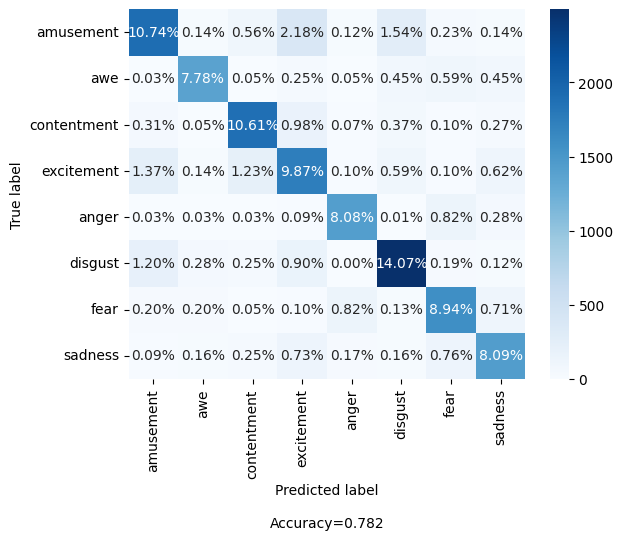

In [80]:
make_confusion_matrix(cf, categories = label["label2idx"].keys(), count = False)

### create accuracy

### 4. Final visual product: Classifing visual emotions on a movie. 

Creating classifications for each frame

In [23]:
import cv2
import pandas as pd
from transformers import pipeline
import time
from PIL import Image


classifier = pipeline("image-classification", model=final_step , device = cuda.current_device())

n_frame = 0

vidcap = cv2.VideoCapture(movie_path)

all_frames_classify = []

success = True

start = time.time()
while(success):
    success,image = vidcap.read()
    if not success:
        break

    if count%1000 == 0:
        print('Read a new frame %06d :' % n_frame, success)
        

    
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(n_frame*40))
        
    img_classify = Image.fromarray(image)

    result = classifier(img_classify)
    result = {value["label"] : value["score"] for value in result}
    result["n_frame"] = n_frame
    n_frame += 1
    all_frames_classify.append(result)

/home/matiasfg/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Creating and saving in CSV final dataframe

In [24]:
df = pd.DataFrame.from_records(all_frames_classify)
df = df.fillna(0)
df.to_csv(movie_name +".csv")
df

,LABEL_5,LABEL_4,LABEL_0,LABEL_2,LABEL_3,n_frame,LABEL_1,LABEL_6,LABEL_7
0,0.950636,0.036102,0.011372,0.001643,0.000244,0,0.0,0.0,0.0
1,0.950636,0.036102,0.011372,0.001643,0.000244,1,0.0,0.0,0.0
2,0.950636,0.036102,0.011372,0.001643,0.000244,2,0.0,0.0,0.0
3,0.950636,0.036102,0.011372,0.001643,0.000244,3,0.0,0.0,0.0
4,0.950636,0.036102,0.011372,0.001643,0.000244,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
161833,0.950623,0.036112,0.011376,0.001643,0.000244,161833,0.0,0.0,0.0
161834,0.950623,0.036112,0.011376,0.001643,0.000244,161834,0.0,0.0,0.0
161835,0.950623,0.036112,0.011376,0.001643,0.000244,161835,0.0,0.0,0.0
161836,0.950623,0.036112,0.011376,0.001643,0.000244,161836,0.0,0.0,0.0


Describing dataset.

In [25]:
df.describe()

,LABEL_5,LABEL_4,LABEL_0,LABEL_2,LABEL_3,n_frame,LABEL_1,LABEL_6,LABEL_7
count,161838.000000,161838.000000,161838.000000,161838.000000,161838.000000,161838.00000,161838.000000,161838.000000,161838.000000
mean,0.364299,0.165021,0.294488,0.007561,0.104871,80918.50000,0.034626,0.023865,0.000013
std,0.379034,0.199177,0.346236,0.023239,0.219271,46718.75077,0.086725,0.064130,0.000296
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.015473,0.004461,0.000057,0.000000,40459.25000,0.000000,0.000000,0.000000
50%,0.195164,0.083619,0.091691,0.002319,0.004836,80918.50000,0.000004,0.000000,0.000000
75%,0.778843,0.238531,0.606497,0.009338,0.074722,121377.75000,0.020055,0.002098,0.000000
max,0.999696,0.978683,0.992317,0.776791,0.999996,161837.00000,0.939135,0.716871,0.025277


Creating caption function to visualize the classification.

In [106]:
import numpy as np
import cv2

def create_captions(img_rgb, results):

    # Write some Text

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    widthFont              = 50
    step                   = 25
    height_font            = range(80, 281, step)
    fontScale              = 1
    fontColor              = (255,255,255)
    thickness              = 1
    lineType               = 2


    for height,feeling in zip(height_font, colors_feelings):
        cv2.putText(img_rgb,
                    feeling, 
                    (widthFont, height), 
                    font, 
                    fontScale,
                    fontColor,
                    thickness,
                    lineType)
        
        color = (colors_feelings[feeling][0]*results[feeling],
                colors_feelings[feeling][1]*results[feeling],
                colors_feelings[feeling][2]*results[feeling])
        
        cv2.rectangle(img_rgb,
                      (widthFont - step - 10,height - int(step * (fontScale - 0.2))),
                      (widthFont - 10,height),
                      color, -1)
    
    
    return img_rgb

Create functions to tint image. 



In [107]:
#combine different RGB in differente leves values to create a unique final color.
def combine_rgb_values(d):
  d_items = sorted(d.items())
  tot_weight = sum(d.values())  
  red = int(sum([colors_feelings[k][0]*v for k, v in d_items])/tot_weight)
  green = int(sum([colors_feelings[k][1]*v for k, v in d_items])/tot_weight)
  blue = int(sum([colors_feelings[k][2]*v for k, v in d_items])/tot_weight)
  return (red, green, blue)

#Mix original image with the specified color ina proportion of 6/4
def tint_image(img, r, g, b):
    
    colored_img = np.zeros((img.shape), dtype=np.uint8)
    colored_img[:] = (r,g,b)

    tinted_image = cv2.addWeighted(img, 0.6, colored_img, 0.4, 0)
    
    return tinted_image

Processing the frames to get the caption and tint.

In [108]:
import cv2

n_frame = 0
vidcap = cv2.VideoCapture(movie_path)
success, img = vidcap.read()
height, width, channels = img.shape

df = pd.read_csv(movie_name + ".csv",index_col = "n_frame").drop("Unnamed: 0", axis=1)
last_r, last_b, last_g = 0, 0, 0
last_result = dict(df.loc[0])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(movie_name + '_output.avi', fourcc, 25, (width, height))

for n_frame, row in df.iterrows():
    success,img = vidcap.read()
    if not success:
        print('Read a new frame %06d :' % n_frame, success)
        break
    elif(n_frame%600 == 0 and n_frame != 0):
        print('Read a new frame %06d :' % n_frame, success)
        break
    
    result = dict(row)
    
    soft_result = {feeling: (result[feeling]*2 + last_result[feeling])/3 for feeling in row.keys()}
    
    
    r, g, b = combine_rgb_values(soft_result)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tinted_image = tint_image(img, r, g, b)

    captioned_image = create_captions(tinted_image, result)
    
    captioned_image = cv2.cvtColor(captioned_image, cv2.COLOR_RGB2BGR)
    out.write(captioned_image)

    vidcap.set(cv2.CAP_PROP_POS_MSEC,(n_frame*40))
    

out.release()

Read a new frame 000600 : True


Create empty image to visualize only caption format. 

In [100]:
fake_img = np.zeros((1080, 1920,3), np.uint8)


fake_result = { 'anger': 1, 'fear': 1,
                   'disgust': 1, "sadness": 1,
                  'awe': 1, "amusement": 1,
                  'excitement' :  1, 'contentment' : 1}

fake_final_image = create_captions(fake_img, fake_result)
fake_final_image = cv2.cvtColor(fake_final_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("out.jpg", fake_final_image)

True